# Machine Learning in Python using Scikit-Learn

## The Problem:
### Can we identify the Line of Business of loss data from a loss triangle?

*This notebook is inspired by a talk by Clark, Ranglova and Oda at the 2017 CLRS*


## The Dataset

* CAS Loss Reserve Database for Workers' Compensation, Medical Malpractice, and Private Passenger Auto
* Top 19 companies with remainder of industry as 20th observation
* Volume-weighted LDFs generated

In [1]:
import pandas as pd
ldf = pd.read_csv(
    r'https://raw.githubusercontent.com/PirateGrunt/paw_rpm/master/notebooks/assets/links.csv',
    index_col=['GRNAME','LOB'])
ldf.head()

,,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
GRNAME,LOB,,,,,,,,,
Alaska Nat Ins Co,wkcomp,2.042044,1.204090,1.078956,1.039735,1.019448,1.014162,1.007755,1.006170,1.001740
Allstate Ins Co Grp,wkcomp,2.222958,1.337730,1.158433,1.092734,1.058643,1.045544,1.031408,1.036089,1.010920
Amerisafe Grp,wkcomp,2.083829,1.230349,1.049066,1.015398,1.011420,1.006666,1.007410,1.011116,1.013069
Associated Industries Ins Co,wkcomp,2.108629,1.353189,1.184505,1.078169,0.974303,1.034001,1.042462,1.042313,1.012176
Beacon Mut Ins Co,wkcomp,2.245266,1.342916,1.156806,1.089594,1.000000,1.000000,1.000000,1.000000,1.000000


# What is Scikit-Learn?

**Machine Learning in Python**

* Simple and efficient tools for data mining and data analysis
* Accessible to everybody, and reusable in various contexts
* Built on NumPy, SciPy, and matplotlib
* Open source, commercially usable - BSD license


#### scikit-learn covers the majority of supervised and unsupervised ML techniques available today and  is continually expanding
![](https://scikit-learn.org/stable/_static/ml_map.png)

##### It's all about the API

`sklearn` is the defacto standard Machine Learning API for Python.  Other libraries yield to the simplicity of its API. 


* Want to do some Keras Deep learning?  No problem, just use `keras.wrappers.scikit_learn`
* XGBoost anyone?  Use: `xgboost.sklearn`
* Don't want to learn the syntax for the Light GBM? `lightgbm.sklearn` to the rescue.
* Natural langauge processing requires unique functionality, right? Nope, `nltk.classify.scikitlearn`


##### Scikit-learn is a consistent API for all Machine Learning Algorithms

Estimators are the building block of scikit-learn.  Almost everything is an estimator.  All estimators have `fit()` methods. Most have either a `predict()` or `transform()` method. Supervised techniques generally have a `score()` method as well.

The basic ML workflow looks like this:
```python
from sklearn.EstimatorFamily import Estimator
est = Estimator(hyperparameter_1, ... ,hyperparameter_n) # Create a model
est.fit(X_train, y_train) # Fit the model
est.score(X_test, y_test) # Evaluate model efficacy
est.predict(X_test) # Create predictions
```

##### Importing your estimators
`from sklearn.EstimatorFamily import Estimator` is typically how you'd import an estimator.  Some examples are:
``` python
from sklearn.linear_model import RidgeRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
```

In [0]:
from sklearn.neighbors import KNeighborsClassifier

##### Hyperparameters of your estimarors (Controlling how your estimator fits)
Instantiating an estimator typically looks like `est = Estimator(hyperparameter_1, ... ,hyperparameter_n)`.
Upon instantition you have the *option* of setting hyperparameters (i.e. parameters whose values are set before the learning process).  All hyperparameters have defaults that may or may not be satisfactory for your particular problem.

Exmaples of setting initial hyperparameters on an estimator:
```python
rr = RidgeRegression(alpha=0.5, fit_intercept=False, normalize=True)
knc = KNeighborsClassifier(n_neighbors=10)
gbc = GradientBoostingClassifier()
```

##### Transformers - a special kind of estimator
Several `sklearn` estimators implement a `transform()` method.  Transformers are typically used to 'transform' your featureset in a way that will improve another algorithms (e.g. regressor, classifier) performance.

Typical examples include:
```python
sklearn.preprocessing.PCA # Principle Components transformation
sklearn.preprocessing.OneHotEncoder # Categorical to dummy transformation
sklearn.preprocessing.StandardScaler # Removing the mean and scaling to unit variance for each feature
sklearn.preprocessing.LabelEncoder # Single-column label to integer tranformation
```

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
response = ldf.index.get_level_values('LOB')
le.fit(response)

LabelEncoder()

##### Mutating the Estimator with fit()
Though it looks like nothing happened, a lot happened under the hood.  Our estimator has seen data can now be applied to new datasets.  Once an estimator is fit, it spin off useful metadata that describes the fit model.  `sklearn` uses a trailing underscore in property names to help users distinguish between hyperparameters and the new metadata.
```python
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
print(lr.fit_intercept) # A hyperparameter.  Returns False.
print(lr.coef_) # Trailing underscore denotes the property comes from a 'fit'.  Returns model coefficients.
```

Additionally the predict, transform, and score methods (if applicable) become available.

In [4]:
le.classes_

array(['medmal', 'ppauto', 'wkcomp'], dtype=object)

### Supervised Learning Example - Identifying the line of business of an unlabeled triangle
We've computed the volume weighted development patterns of twenty companies for each line of business, `wkcomp`, `comauto`, and `ppauto` and want to use them to train a Machine Learning model that can identify the appropriate line of business.

Defining this problem more concretely:<br>
The LDFs are our featureset, **X**, and the known line of business is our response, **y**.

In [0]:
X = ldf.values
y = le.transform(response)

##### Train/Test Split
It is best practice in machine learning to evaluate models on a test set of data.  Since this is covered substantially in other literature, we will not go into the details of why here.  `sklearn` comes with several utilities to split data, but we will explore the simplest one.

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=42)
```

`train_test_split` returns a tuple of our features/response split into training and test sets. The `random_state` argument shows up in a lot of places in `sklearn`.  Generally, when there is a stochastic component to the `sklearn` component you are using, `random_state` is there to allow you to set a seed so that your work can be replicated.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=42)

##### Fitting our classifier
Our data is in a numerical format, its been split, and now we are ready to do some Machine Learning.  

Don't forget, when fitting any supervised learning technique, you must specify both your featureset and your response in the `fit` method.

In [7]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.85

##### Trying another classifier
Remember the `sklearn` API was designed to make using different algorithms as consistent as possible. This means the same code should require minimal changes when applied to another classifier.

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

for model in [RandomForestClassifier(n_estimators=10),
              GradientBoostingClassifier(),
              XGBClassifier(),
              LogisticRegression(solver='lbfgs', multi_class='auto'),
              RidgeClassifier(),
              KNeighborsClassifier()]:
    model.fit(X_train, y_train)
    print(f'{model.__class__.__name__} holdout accuracy:',
          model.score(X_test,y_test))

RandomForestClassifier holdout accuracy: 0.8
GradientBoostingClassifier holdout accuracy: 0.8
XGBClassifier holdout accuracy: 0.85
LogisticRegression holdout accuracy: 0.8
RidgeClassifier holdout accuracy: 0.6
KNeighborsClassifier holdout accuracy: 0.85


##### Cross-validation
* `sklearn` provides a `cross_val_score` to test the accuracy of an estimator across multiple folds painting a truer picture of an estimators' efficacy than a simple train/test split.
* With `cross_val_score`, we don't really need to provide separate train and test sets.  Though, with enough data, it is sometimes instructive to have train/test and holdout 

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np

knn = KNeighborsClassifier()
np.mean(cross_val_score(knn, X, y, cv=5))

0.8333333333333334

##### Improving model accuracy with GridSearchCV

With `GridSearchCV`, we can feed a hyperparameter grid into our estimator to determine an 'optimal' set of hyperparameters to use for our particular business problem.  `GridSearchCV` itself is an estimator and so it has the usual `'fit()` and `predict()` methods any other classifier would.

At a minimum, parameterizing the GridSearchCV estimator we need to specify:
1. The estimator we want to use
2. The hyperparameter searchspace as a dictionary

Optionally, we can also specify:
1. The number of folds to use

In [10]:
from sklearn.model_selection import GridSearchCV
param_grid=dict(n_neighbors=[1,3,5,7,9,11], p=[1,2,3,4,5,6])
grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X, y)
print(f'Best Score: {grid.best_score_}')
grid.best_estimator_

Best Score: 0.8666666666666667


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=3,
           weights='uniform')

Holding `p=3` constant, a visual inspection of the cross-validated scores shows support for `n_neighbors=3`

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


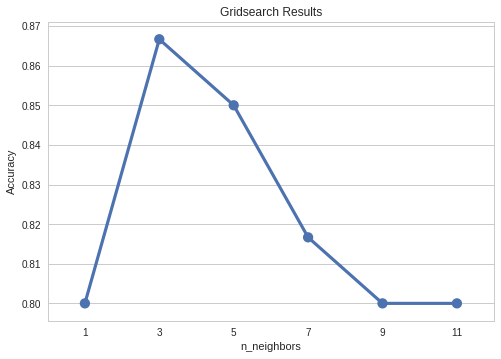

In [11]:
import seaborn as sns
sns.set_style('whitegrid')
p_3 = grid.cv_results_['param_p']==3
g = sns.pointplot(x=grid.cv_results_['param_n_neighbors'][p_3],
                  y=grid.cv_results_['mean_test_score'][p_3]) \
       .set(xlabel='n_neighbors', ylabel='Accuracy', title='Gridsearch Results')

#### Confusion Matrix
It looks like our classifier struggles more to distinguish between private passenger auto and workers' compensation.

In [12]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y, grid.best_estimator_.predict(X)),
             index=le.classes_, columns=le.classes_)

,medmal,ppauto,wkcomp
medmal,19,1,0
ppauto,0,17,3
wkcomp,0,3,17


##### Visual representation of the data
By inspection (at least across the first three development ages), it is more difficult to distinguish between `wkcomp` and `ppauto` in line with where our classifiers are least accurate.

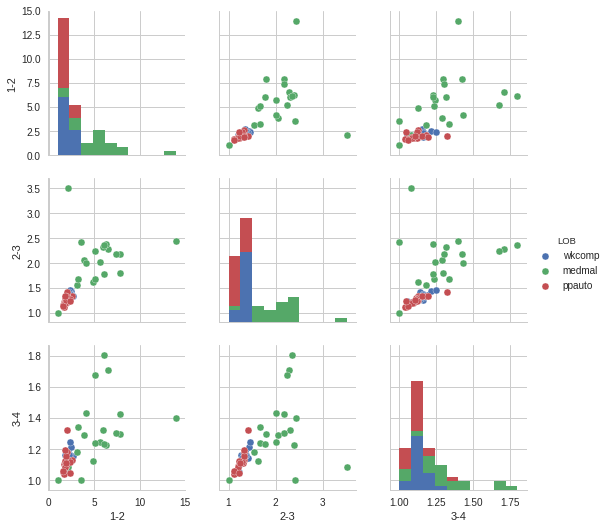

In [13]:
plot_data=ldf.reset_index().iloc[:,1:].set_index('LOB').T

g = sns.pairplot(ldf.reset_index()[['LOB','1-2','2-3','3-4']], hue="LOB")

### More complex workflows with Pipeline

The authors of `sklearn` recognize that composability of multiple estimators will be necessary to build the best models.  For example, you may want to cluster a feature before feeding it into a Regressor.

The `Pipeline` is useful for chaining one or more transformers together.  Pipelines themselves are estimators and have `fit()`, `predict()`, and `score()` function and can be used with all of the `sklearn` funcitons used for regular estimators including but not limited to: `cross_val_score`, `confusion_martix`

Adding a PCA step with no hyper-parameter tuning actually reduces our cross validation accuracy score.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

steps=[('pca', PCA()),
       ('knn',KNeighborsClassifier(n_neighbors=3, p=3))]

pipe = Pipeline(steps=steps)
np.mean(cross_val_score(pipe, X, y,cv=5))

0.85

##### Can we do better with parameter tuning?

#### Pipelines and GridSearchCV
Since a `Pipeline` is just another estimator `GridSearchCV` allows the hyperparameter space of all estimators in the pipeline to be gridsearched in one go.  

To avoid hyperparameter name clashes between one estimator and another within a pipeline, `sklearn` uses a double underscore naming convention of the form {estimator_name}__{hyperparameter} for the keys of its parameter grid.


We achieve parity with the highest accuracy of our original classifier.  In this instance, adding the Principle Components step did not yield any better results.

In [15]:
param_grid=dict(knn__n_neighbors=[1,3,5,7,9,11],
                knn__p=[1,2,3,4,5,6],
                pca__n_components=[3, 5, 7, 9])

pipe = Pipeline(steps=[('pca', PCA()),
                       ('knn',KNeighborsClassifier())])

grid = GridSearchCV(pipe, param_grid, cv=5, refit=True)
grid.fit(X, y)

print(f'Best Score: {grid.best_score_}')
grid.best_estimator_

Best Score: 0.8666666666666667


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=6,
           weights='uniform'))])

### Scikit-Learn Recap

* Almost everything is an Estimator.  They all have a `fit` method and depending on the nature of the estimator may also have a `predict`, `score` or `transform` method.
* The API is standardized across estimator
* A transformer is a special type of estimator that trasnforms data for another Estimator
* Cross-validation with Grid Search helps in hyperparameter selection
* Pipelines are useful for composing a chain of Estimators.
* The documentation is a goldmine of information
